In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

## Постановка задачи

### Проблема:
Booking — американский поисковик-агрегатор, позволяющий бронировать места в ресторанах, отелях, арендовать авто и т.д. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

### Задача:
Создать модель, которая должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных. 

In [3]:
import statistics
import category_encoders as ce
import re # регулярные выраженияcategory_encoders

#Визуализация графиков
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# подгрузим данные из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR + '/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR + 'hotels_test.csv') # датасет для тестирования
sample_submission = pd.read_csv(DATA_DIR + '/submission.csv') #submission

In [5]:
# посмотрим информацию по загруженным данным
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,9/22/2015,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotles...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,3/5/2016,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Break...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644


In [9]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [10]:
sample_submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [11]:
# объединим train и test в один датасет
df_train['sample'] = 1 
df_test['sample'] = 0 
df_test['reviewer_score'] = 0 #для объединения присвоим значение 0 reviewer_score - целевой признак в тестовой выборке

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) #объединение датасетов
hotels

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515733,9 Knaresborough Place Kensington and Chelsea L...,107,4/19/2017,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.494028,-0.191050,1,8.8
515734,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2/13/2017,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrie...,93,1,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.192379,16.399451,1,9.2
515735,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2/7/2016,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in L...,12,2751,great location simple check in out nice shower,9,21,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.520795,-0.131084,1,8.3
515736,31 Great Cumberland Place Westminster Borough ...,365,5/21/2017,8.1,The Marble Arch London,United Arab Emirates,No Negative,0,1567,Location and very comfy bed,6,28,"[' Leisure trip ', ' Solo traveler ', ' Deluxe...",74 days,51.515125,-0.160066,1,9.2


## Информация о датасете

Первоначальная версия датасета содержит 17 полей со следующей информацией:

* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыве;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

Размер таблицы: (386803;17)
Пропуски в данных: 'lat', 'lng'

In [12]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [13]:
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


In [14]:
# заполним пропуски в признаках lat и lng медианным значением
def fill_blanks(df, sign): 
    sign_mode = round(statistics.median(df[sign]), 6)
    df.fillna(value={sign: sign_mode}, inplace=True)
    return df

sign_to_fill = ['lat', 'lng']

for sign in sign_to_fill:
    hotels = fill_blanks(hotels, sign) 

<AxesSubplot:>

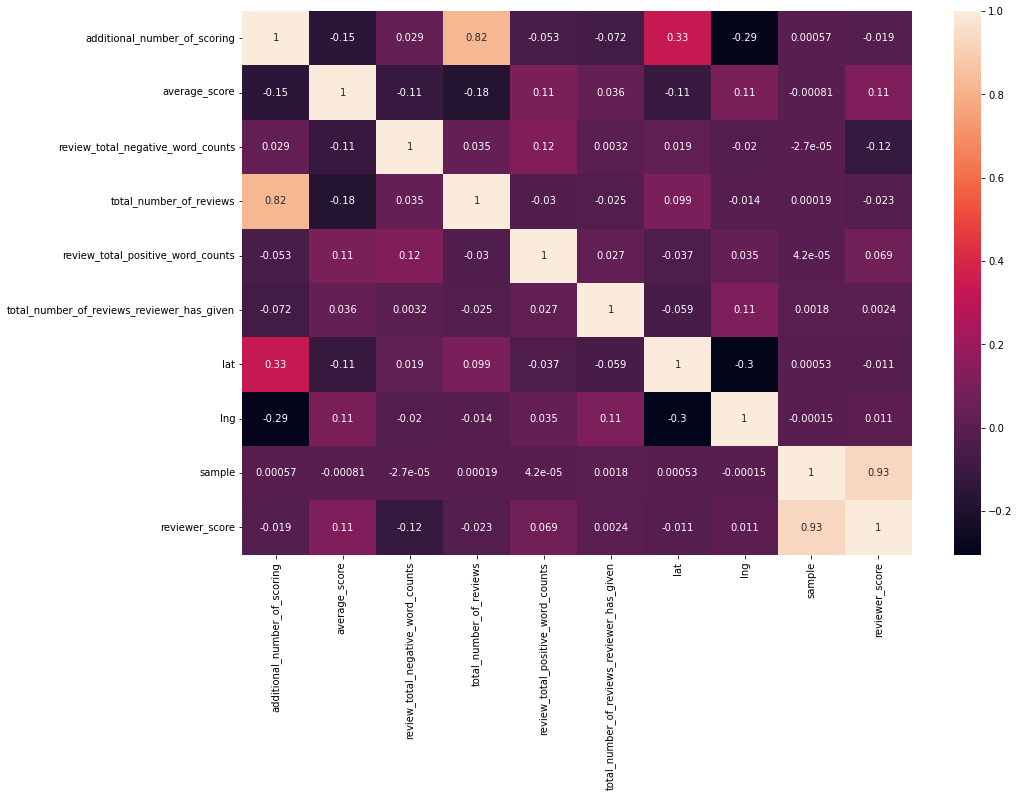

In [15]:
# построим тепловую матрицу корреляций

plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(hotels.corr(), annot=True)

In [16]:
#Признаки total_number_of_reviews и additional_number_of_scoring имеют сильную корреляцию, удалим один из признаков
hotels.drop(columns='additional_number_of_scoring', inplace=True)

Признаков типа object  а данной таблице всего 8:
1. hotel_address 
2. review_date 
3. hotel_name 
4. reviewer_nationality 
5. negative_review
6. positive_review
7. tags 
8. days_since_review 

### Подзадача:
Получить информацию из признаков типа object, которая может пригодиться для обучения модели.

## Обработка признаков типа object

### 1. review_date

In [17]:
# Преобразуем информацию о дате в формат datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'],yearfirst=True)

#Вынесем информацию о годе и месяце в отдельные признаки
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_month'] = hotels['review_date'].dt.month

#Удалим исходный признак
hotels = hotels.drop('review_date',axis=1)

### 2. tags

Признак 'tags' содержит информацию о тэгах пользователей, оставленных в каждом коментариии к отелю, инфромация в ячейках представлена в виде строки. Нам необходимо получить из строки список тэгов. 

In [18]:
# Функция принимает строку с тэгами и возвращает список тэгов
def get_tags_list(tags_str):

    tags_list = tags_str[1:-1] # удаляем скобки вначале и в конце строки
    tags_list = tags_list.replace("' ","") # удаляем кавычки вначале тэга
    tags_list = tags_list.replace(" '","") # удаляем кавычки вконце тэга
    tags_list = tags_list.split(', ') # разделяем строку на отдельные тэги
    return tags_list

hotels['tags'] = hotels['tags'].apply(get_tags_list)

Попробуем выяснить какие тэги пользователи оставляли чаще, а какие реже.

In [19]:
# Функция принимает на вход список тэгов
# и возвращает словарь тэгов, где значения - количество их повтров в ячейках таблицы

uniq_tags_dict = dict() # задаем словарь, в который будем добавлять тэги

def tags_count(tags_list):
    for elem in tags_list:
        if elem in uniq_tags_dict.keys():
            uniq_tags_dict[elem] = int(uniq_tags_dict.get(elem)) + 1 
        else:
            uniq_tags_dict[elem] = 1
    return(uniq_tags_dict)
    
hotels['tags'].apply(tags_count)

# Количество уникальных тэгов в таблице
print("Количество уникальных тэгов в таблице:",len(uniq_tags_dict))

# Отсоритируем словарь с тэгами по значению в порядке убывания (сохранение порядка элементов словаря
# не гарантируется в версиях Python старше 3.7) 

sorted_values = sorted(uniq_tags_dict.values(),reverse=True) # Создадим отсортированный список со значениями 
sorted_dict = {} # пустой словарь, куда будем добавлять отсортированные ключи со значениями

for i in sorted_values:
    for k in uniq_tags_dict.keys():
        if uniq_tags_dict[k] == i:
            sorted_dict[k] = uniq_tags_dict[k]
            break

print(sorted_dict)

Количество уникальных тэгов в таблице: 2428
{'Leisure trip': 417778, 'Submitted from a mobile device': 307640, 'Couple': 252294, 'Stayed 1 night': 193645, 'Stayed 2 nights': 133937, 'Solo traveler': 108545, 'Stayed 3 nights': 95821, 'Business trip': 82939, 'Group': 65392, 'Family with young children': 61015, 'Stayed 4 nights': 47817, 'Double Room': 35207, 'Standard Double Room': 32248, 'Superior Double Room': 31393, 'Family with older children': 26349, 'Deluxe Double Room': 24823, 'Double or Twin Room': 22393, 'Stayed 5 nights': 20845, 'Standard Double or Twin Room': 17483, 'Classic Double Room': 16989, 'Superior Double or Twin Room': 13570, '2 rooms': 12393, 'Stayed 6 nights': 9776, 'Standard Twin Room': 9745, 'Single Room': 9670, 'Twin Room': 8321, 'Stayed 7 nights': 7399, 'Executive Double Room': 6425, 'Classic Double or Twin Room': 6107, 'Superior Twin Room': 6064, 'Deluxe Double or Twin Room': 5998, 'Club Double Room': 5908, 'Queen Room': 5472, 'Deluxe King Room': 5357, 'Superior 

Итак, в таблице 2368 уникальных тэга, из них чаще всего используется тэг 'Leisure trip' - 313593 раз, 
реже всего тэг 'King Room with Sea View' - 1 раз. Тэги, которые редко используют пользователи, не несут для нас полезной информации поэтому можно оставить только те тэги, которые чаще встречаются в датасете.

In [20]:
# Составим список топ-20 тэгов
top_tags = list(sorted_dict.keys())[:20]

# По каждому тэгу создадим отдельный признак, который будет содержать информацию о наличии или отутсвии тэга 
for tag in top_tags:
    hotels[tag] = hotels.tags.apply(lambda x: 1 if tag in x else 0)
    
# Удаляем исходный столбец
hotels = hotels.drop('tags',axis=1)

### 3. days_since_review

Признак days_since_review содержит информацию о количестве прошедших дней с момента создания отзыва в формате строки, вынесем из этого признака число дней

In [21]:
# Функция принимает на вход строку и возвращает из нее число
def get_day_count(string):
    pattern = re.compile(r'\d+') #задаем паттерн для поиска числа в строке
    day_count = int(pattern.findall(string)[0]) #применяем паттерн и преобразуем строку в число
    return day_count

# Применим функцию к признаку days_since_review
hotels['days_since_review'] = hotels['days_since_review'].apply(get_day_count)

### 4. hotel_address

В адрессе старана, где находится отель обозначена в конце адресса. Наша задача попробовать получить из этой строки только название станы, в которой находится отель.

Заметим, что национальность интервьюера записана в таком же формате, как название страны в адрессе отеля (т.е. без окончаний, только название страны), значит отсюда мы можем получить список из названий стран.

In [22]:
nat_list = list(hotels.reviewer_nationality.value_counts().index) # получаем названия национальностей
# Для корректного поиска удаляем пробел в конце каждоый строки
count_list = []
for nat in nat_list:
    nat = nat[:-1]
    count_list.append(nat)
# Получаем список названий стран
count_list

[' United Kingdom',
 ' United States of America',
 ' Australia',
 ' Ireland',
 ' United Arab Emirates',
 ' Saudi Arabia',
 ' Netherlands',
 ' Switzerland',
 ' Germany',
 ' Canada',
 ' France',
 ' Israel',
 ' Italy',
 ' Belgium',
 ' Turkey',
 ' Kuwait',
 ' Spain',
 ' Romania',
 ' Russia',
 ' South Africa',
 ' India',
 ' Greece',
 ' China',
 ' Sweden',
 ' New Zealand',
 ' Singapore',
 ' Hong Kong',
 ' Poland',
 ' Qatar',
 ' Austria',
 ' Egypt',
 ' Norway',
 ' Czech Republic',
 ' Lebanon',
 ' Hungary',
 ' Malaysia',
 ' Thailand',
 ' Brazil',
 ' Portugal',
 ' Finland',
 ' Denmark',
 ' Malta',
 ' Bahrain',
 ' Indonesia',
 ' Cyprus',
 ' Luxembourg',
 ' Croatia',
 ' Oman',
 ' Bulgaria',
 ' Japan',
 ' Serbia',
 ' Ukraine',
 ' Iran',
 ' South Korea',
 ' Philippines',
 ' Nigeria',
 ' Iceland',
 ' Taiwan',
 ' Pakistan',
 ' Slovakia',
 ' Jersey',
 ' Slovenia',
 ' Estonia',
 ' Jordan',
 ' Lithuania',
 ' Latvia',
 ' Mexico',
 ' Guernsey',
 '',
 ' Argentina',
 ' Isle of Man',
 ' Gibraltar',
 ' Chile'

In [23]:
# Функция принимает на вход строку и если название страны есть найдено в строке, 
# функция вернет только назвние страны, в которой находится отель.

def get_country(adress):
    for elem in count_list:
        if elem in adress:            
            return elem

# Получим новый признак с информацией о стране, в которой находится отель        
hotels['hotel_country'] = hotels['hotel_address'].apply(get_country) 
# Удалим признак с полным адрессом отеля
hotels = hotels.drop('hotel_address',axis=1)

In [24]:
print('Отели в датасете располагаются в',hotels['hotel_country'].nunique(),'странах')

Отели в датасете располагаются в 6 странах


In [25]:
# Количество стран небольшое, значит данный признак можно закодировать
hotels = pd.get_dummies(hotels, columns=['hotel_country'])

### 5. reviewer_nationality

In [26]:
print("Количество уникальных значений",hotels['reviewer_nationality'].nunique())

Количество уникальных значений 227


In [27]:
# Топ 20 национальностей рецензентов
top_nat_list = list(hotels['reviewer_nationality'].value_counts().index[:20])

# По каждой национальности рецензента создадим отдельный признак
for nat in top_nat_list:
    hotels[nat] = hotels.reviewer_nationality.apply(lambda x: 1 if nat in x else 0)
    
hotels = hotels.drop('reviewer_nationality',axis=1)   

### 6. hotel_name

Названия некоторых отелей в таблице повторяются более 1500 раз, что говорит о том, что данные отели являются сетевыми.
На основе этой информации можно создать признак, который будет свидетельствовать о том, является отель частью большой сети отелей или нет.

In [28]:
# Создадим список топ 20 названий отелей по количеству отелей в сети
top_20_hotel_names = hotels.hotel_name.value_counts()[:20]
top_20_hotel_names = list(top_20_hotel_names.index)

# Признак chain_hotel содержит информацию о принадлежности 
# или непринадлежности отеля к большой сети
hotels['chain_hotel'] = hotels.hotel_name.apply(
    lambda x: 1 if x in top_20_hotel_names else 0
    )

# Удалаяем столбец hotel_name
hotels = hotels.drop('hotel_name',axis=1)

### 7. negative_review

Заменим некоторые коментарии, которые на самом деле не несут в себе нагативного посыла на строку 'Positive'

In [29]:
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('No Negative','Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('N A','Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('All good','Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('No complaints','Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('Nothing to dislike','Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace(' Nothing','Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace(' nothing','Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('N a','Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace(' Positive','Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('Positive ','Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('Positive really','Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace(' None','Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace(' ','Positive')) #Заменит все пробелы в ячейках на Positive

# Здесь мы учтем только те строки, которые полностью равны Positive 
# им присваиваем значение 0 остальным 1
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: 0 if x=='Positive' else 1)

### 8. positive_review

Заменим некоторые коментарии, которые на самом деле не несут в себе позитивного посыла на строку 'Negative'

In [30]:
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative')) 
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: x.replace(' Nothing', 'Negative'))
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: x.replace('Negative ', 'Negative'))
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: x.replace('nothing', 'Negative'))
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: x.replace(' Negative', 'Negative'))
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: x.replace(' ', 'Negative')) #Заменит все пробелы в ячейках на Negative

# Здесь мы учтем только те строки, которые полностью равны Negative 
# им присваиваем значение 0 остальным 1
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: 0 if x=='Negative' else 1)

In [31]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 61 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   negative_review                             515738 non-null  int64  
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   total_number_of_reviews                     515738 non-null  int64  
 4   positive_review                             515738 non-null  int64  
 5   review_total_positive_word_counts           515738 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 7   days_since_review                           515738 non-null  int64  
 8   lat                                         515738 non-null  float64
 9   lng                                         515738 non-null  float64
 

### Дополнительно

In [32]:
# Теперь для всех положительных отзывах, которые попали в Negative 
# исправим значение review_total_negative_word_counts на 0
# аналогично исправим для Positive 
hotels.loc[(hotels.negative_review==0),'review_total_negative_word_counts'] = 0
hotels.loc[(hotels.positive_review==0),'review_total_positive_word_counts'] = 0

## Обучение модели

In [33]:
from sklearn.model_selection import train_test_split  
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [34]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.0997054518107078


<AxesSubplot:>

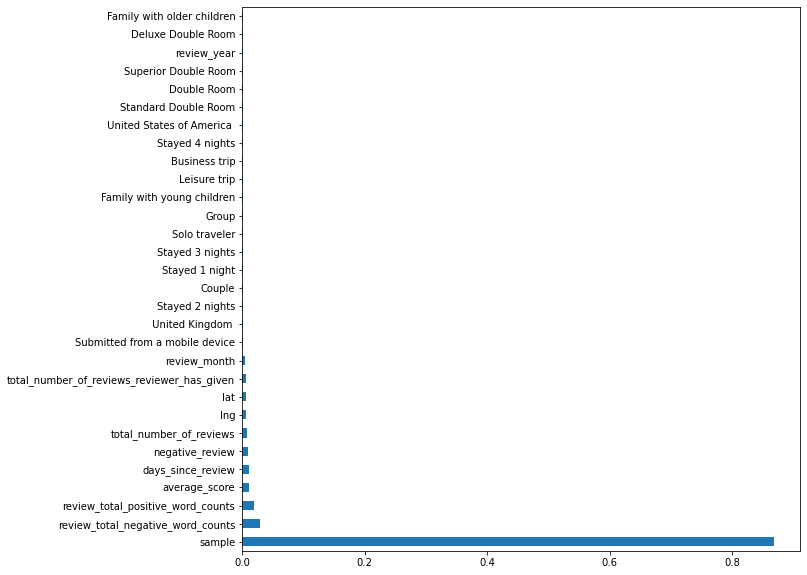

In [35]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

In [36]:
X_test.sample(10)

,average_score,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,...,Israel,Italy,Belgium,Turkey,Kuwait,Spain,Romania,Russia,South Africa,chain_hotel
213179,8.6,1,17,2764,1,5,5,711,48.855566,2.292624,...,0,0,0,0,0,0,0,0,0,0
283782,8.2,1,3,1003,1,10,1,662,51.491908,-0.168440,...,0,0,0,0,0,0,0,0,0,0
5615,7.5,1,8,2197,1,4,1,449,51.491668,-0.194747,...,0,0,0,0,0,0,0,0,0,0
335374,8.6,1,4,4276,1,11,9,491,41.385639,2.166827,...,0,0,0,0,0,0,0,0,0,0
393404,7.7,0,0,6539,1,54,1,614,51.510995,-0.186342,...,0,0,0,0,0,0,0,0,0,1
238144,8.8,1,178,489,1,91,9,279,48.851662,2.297940,...,0,0,0,0,0,0,0,0,0,0
395968,8.2,1,3,1259,1,41,9,177,48.201728,16.375463,...,0,0,0,0,0,0,0,0,0,0
67665,7.2,0,0,182,1,19,2,518,48.869973,2.290940,...,0,0,0,0,0,0,0,0,0,0
398585,8.7,1,45,310,1,79,1,177,41.391908,2.157332,...,0,0,0,0,0,0,0,0,0,0
288067,8.0,0,0,1725,1,59,1,643,41.403622,2.190281,...,0,0,0,0,0,0,0,0,0,0


In [37]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [38]:
predict_submission = regr.predict(X_test)

In [39]:
predict_submission

array([8.779, 9.561, 7.569, ..., 7.831, 6.254, 0.   ])

In [40]:
list(sample_submission)

['reviewer_score', 'id']

In [41]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission3.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.779,488440
1,9.561,274649
2,7.569,374688
3,9.611,404352
4,7.460,451596
5,8.375,302161
6,5.589,317079
7,0.000,13963
8,7.427,159785
9,9.371,195089
